# 투빅스 15기 정규세션 10주차 DCGAN 구현 주석달기 과제
https://github.com/pytorch/tutorials/blob/master/beginner_source/dcgan_faces_tutorial.py  
위의 주소는 pytorch dcgan 공식 튜토리얼 코드입니다.  
위 코드나  아래 코드에 주석을 자유롭게 한글로 달아주시면 됩니다.   
단, # ( ... ) 와 같은 표식이 있는 라인에는 꼭 주석을 달아주세요 !  
튜토리얼 코드와 과제 코드가 상당부분 유사하므로 어려운 점이 있을 때 참고하면 좋습니다. 
또한, 잘 모르는 메서드의 경우 파이토치 공식 docs의 설명을 참고하시면 됩니다.
https://pytorch.org/docs/stable/index.html

## 드라이브 연결

In [ ]:
# gdrive에 mount
from google.colab import drive
drive.mount('/content/gdrive')
# 경로 설정
import os
os.chdir('/content/gdrive/My Drive/')

Mounted at /content/gdrive


## 패키지 임포트

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import random
import torchvision.utils as vutils
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms

## MNIST 데이터 불러오기
기존의 MNIST 손글씨 데이터의 경우 1x28x28 이미지 -> dcgan 모델 적용을 위해 1x64x64 이미지로 크기 조절 (물론 28x28이미지도 사용가능하지만 네트워크 구조 수정 필요)  
처음 데이터를 사용할때는 download=True로 데이터를 다운 받기  
이후에 사용할때는 데이터가 이미 다운되있으므로 download=False로 바꿔서 사용

In [ ]:
# MNIST dataset
dataroot = './mnist_data/'
imageSize = 64 # the height / width of the input image to network

dataset = dset.MNIST(root = dataroot, download= True,
                     transform = transforms.Compose([
                                                     transforms.Resize(imageSize), # 이미지의 사이즈를 64로 변경
                                                     transforms.ToTensor(), # numpy 이미지를 tensor로 변경
                                                     transforms.Normalize((0.5,), (0.5,)), # 노말라이즈를 통해 -1.~1.의 값을 갖도록 변환
                     ]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### 데이터 확인하기

In [ ]:
print('number of training data: ', len(dataset)) # 데이터 수 확인
image,_ = dataset[0] # 데이터는 (이미지, label) 

print('Image')
print('========================================')
print('shape of this image\t:', image.shape) #데이터 차원(모양)확인하기

number of training data:  60000
Image
shape of this image	: torch.Size([1, 64, 64])


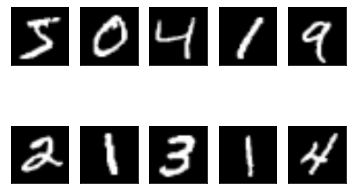

In [ ]:
# 학습 데이터 시각화
fig = plt.figure()

for i in range(10):
    image,_ = dataset[i] 
    image = (image+1)/2 # 0과 1사이로 변경
    image = image.squeeze() # 사이즈가 1인 차원을 스칼라값으로 변환하여 해당 차원 제거
    np_img = image.numpy() # numpy array로 변경
    
    subplot = fig.add_subplot(2, 5, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(np_img, cmap = 'gray')

plt.show()

### 데이터 로더 정의

In [ ]:
# dataloader
batch_size = 128 # 논문과 동일하게
workers = 2

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle = True, num_workers = workers)

## device 정의

In [ ]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 0번 gpu에 cuda 연산 할당
print(device)

cuda:0


## 신경망 

In [ ]:
#네트워크 하이퍼파라미터 설정
nc = 1 # number of channels in the training images (흑백)
nz = 100 # size of z latent vector (논문과 동일)

# 64x64 이미지.
ngf = 64 # size of feature maps in generator
ndf = 64 # size of feature maps in discriminator 


### 신경망 가중치 초기화 함수 정의
신경망의 가중치 초기화 방법에 대해 논문에 자세히 나와있습니다.  
다음 사이트는 파이토치에서 가중치 초기화에 관련된 글 입니다  
https://www.javaer101.com/ko/article/1010427.html

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### 생성자 클래스

trasposed convolution 관련 자료: https://yonghyuc.wordpress.com/2019/08/08/transposed-convolutions-aka-deconvolution/

In [ ]:
class Generator(nn.Module): # 해당 논문의 그림과는 feature map이 다르지만 feature map을 64로 설정했으므로 이를 따른다.
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # z(또는 nz)을 input으로하여 TransposedConV를 거쳐, 이미지로 변환된다. 
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False ), # input channel, output channel, filter size, stride, padding --> 크기는 논문과 동일하게
            nn.BatchNorm2d(ngf * 8), # 배치 정규화
            nn.ReLU(True), # 생성자는 output 제외 모두 ReLU를 사용한다.
            # 크기 : (ngf * 8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False), # 이미지 크기는 2배로 늘리고, channel은 0.5배로 줄이고, stride는 논문과 동일하게.
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # 크기 : (ngf * 4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # 크기 : (ngf * 2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # 크기 : (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # 크기 : (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netG = Generator().to(device) # 생성자 객체 생성
netG.apply(weights_init) # 가중치 초기화

# 생성자 출력
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


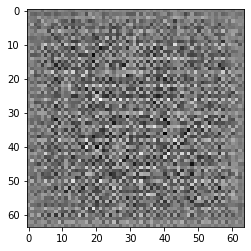

In [ ]:
# 생성자 테스트
test_data=dataloader.dataset[0]
noise=torch.randn(1, nz, 1, 1, device=device) # 1 * nz 크기의 노이즈

test_image=netG(noise)
test_image=test_image.squeeze().cpu().detach().numpy() # gpu에 올라가 있는 tensor를 numpy로 변환
plt.imshow(test_image, cmap = 'gray')


위의 코드로 하여금 가중치 초기화가 된 상태.

### 판별자 클래스

In [ ]:
class Discriminator(nn.Module): # 생성자와 반대로 진행하면 된다.
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential( 
            # input : (nc) x 64 x 64 의 이미지 - 여기서는 nc=1
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False), # generator의 역순으로 레이어를 쌓는다.
            nn.LeakyReLU(0.2, inplace=True),
            # 크기: (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False), # 이미지 크기는 0.5배로, 채널의 크기는 2배로.
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 크기: (ndf * 2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 크기: (ndf * 4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # 크기: (ndf * 8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netD = Discriminator().to(device) # 판별자 객체 생성
netD.apply(weights_init) # 가중치 초기화

# 판별자 출력
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
# 판별자 테스트
test_image=netG(noise)
netD(test_image)

tensor([[[[0.3753]]]], device='cuda:0', grad_fn=<SigmoidBackward>)

아직 학습이 안 되긴 했지만, 위의 생성 이미지는 가짜 이미지로 판단할 것

## Loss Function & Optimizer

In [ ]:
# optimizer hyperparameters
criterion =nn.BCELoss() # binary cross entropy loss function
fixed_noise = torch.randn(64, nz, 1, 1, device=device) # 학습 과정을 보기 위한 노이즈.

real_label = 1. # 진짜 -> 1 라벨
fake_label = 0. # 가짜 -> 0 라벨

# optimizer hyperparameters
learning_rate = 2e-4 # 논문과 동일
beta1 = 0.5 # Adam의 beta1 0.5, 논문과 동일

# optimizers
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

## Train
각각의 변수 및 메소드가 무엇을 나타내는지 혹은 어떻게 계산되는지를 주석으로 설명 부탁드립니다.  
참고하면 좋은 사이트: https://redstarhong.tistory.com/64

### 특정 method에 대해 어떤 역할을 하는 지 간단히 적어주세요.  
torch.Tensor.view() : self tensor와 데이터가 같지만 모양이 다른 새 tensor를 반환  
torch.Tensor.item() : tensor에 value만 추출
torch.Tensor.detach() : graph(연산 기록)로부터 분리한 새 tensor를 반환
torch.Tensor.squeeze() : 사이즈가 1인 차원을 스칼라값으로 변환하여 해당 차원 제거
torch.Tensor.unsqueeze() : 특정한 위치에 1 차원을 추가한 tensor를 반환

In [ ]:
num_epochs = 5 # 더 늘리셔도 됩니다.

# 학습 과정 저장
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ########################
        # (1) 판별자(D) 업데이트 : 식 loss function을 최대화 한다.
        ########################
        # 즉, 기존 이미지인 x를 진짜(1)로 판별하고
        # 생성 이미지인 G(z)를 가짜(0)으로 판별

        ## 진짜 이미지에 대한 학습

        netD.zero_grad() # 기울기 초기화
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0) # batch size.
        label = torch.full((b_size, ), real_label, dtype=torch.float, device=device)
        
        # 예측 결고를 1차원 벡터로 반환
        output = netD(real_cpu).view(-1)
        # output을 1로 잘 예측했는지 계산
        errD_real = criterion(output, label) # label : (batch x 1)
        # 역전파 계산
        errD_real.backward()
        D_x = output.mean().item() 

        ## 가짜 이미지에 대한 학습

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # generator가 가짜 이미지 생성
        fake = netG(noise)
        # 배치사이즈만큼 가짜 레이블(0)으로 채움
        label.fill_(fake_label) 
        # discriminator가 이미지를 판별
        output = netD(fake.detach()).view(-1)
        # output을 0으로 잘 예측했는지 계산
        errD_fake = criterion(output, label)
        # 역전파 계산
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # 진짜 이미지, 가짜 이미지에 대한 loss를 합한다 - 목표 : 이 loss function 최대화
        errD = errD_real + errD_fake # 진짜 이미지, 가짜 이미지에 대한 loss 합하기
        # 판별자(D) 업데이트
        optimizerD.step()

        ########################
        # (2) 생성자(G) 업데이트 : log(D(G(z)))를 최대화한다.
        ########################

        netG.zero_grad()
        label.fill_(real_label) # 배치사이즈만큼 진짜 레이블(1)로 채움.
        # D만 업데이트 된 상태이므로 다시 판별자(D)에 가짜 이미지를 통과.
        output = netD(fake).view(-1)
        # loss function 계산
        errG = criterion(output, label)
        # 역전파 계산
        errG.backward()
        D_G_z2 = output.mean().item()
        # 생성자(G) 업데이트
        optimizerG.step()

        # 학습 경과 출력
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
            % (epoch, num_epochs, i, len(dataloader),
                errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
        # loss history 저장
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # noise가 고정되어있을 때 생성자(G)가 생성하는 image history 저장
        # 더 자주 이미지를 저장하고 싶은 경우 아래 코드 수정(e.g., 500 -> 200)
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        

[0/5][0/469]	Loss_D: 1.7192	Loss_G: 5.9941	D(x): 0.6156	D(G(z)): 0.6248 / 0.0036
[0/5][50/469]	Loss_D: 0.0011	Loss_G: 40.9346	D(x): 0.9990	D(G(z)): 0.0000 / 0.0000
[0/5][100/469]	Loss_D: 0.0009	Loss_G: 40.7982	D(x): 0.9991	D(G(z)): 0.0000 / 0.0000
[0/5][150/469]	Loss_D: 0.0004	Loss_G: 40.6006	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[0/5][200/469]	Loss_D: 0.0000	Loss_G: 40.4789	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][250/469]	Loss_D: 0.0000	Loss_G: 40.5313	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][300/469]	Loss_D: 0.0000	Loss_G: 40.1614	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][350/469]	Loss_D: 0.0000	Loss_G: 40.1014	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][400/469]	Loss_D: 0.0001	Loss_G: 40.1521	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[0/5][450/469]	Loss_D: 0.0001	Loss_G: 40.1043	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[1/5][0/469]	Loss_D: 0.0000	Loss_G: 39.9397	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][50/469]	Loss_D: 0.0000	Loss_G: 39.8159	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000

## Loss에 대한 설명을 해주세요.
- Loss_D : Discriminator의 loss
- Loss_G : Generator의 loss
- D(x) : Discriminator가 진짜 이미지를 예측한 점수의 평균
- D(G(z)) : Discriminator가 Generator가 생성한 가짜 이미지에 대해 예측한 점수의 평균


# 결과

### 학습 과정에서 변하는 Loss 해석하기
> 참고하면 좋은 사이트 : https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/

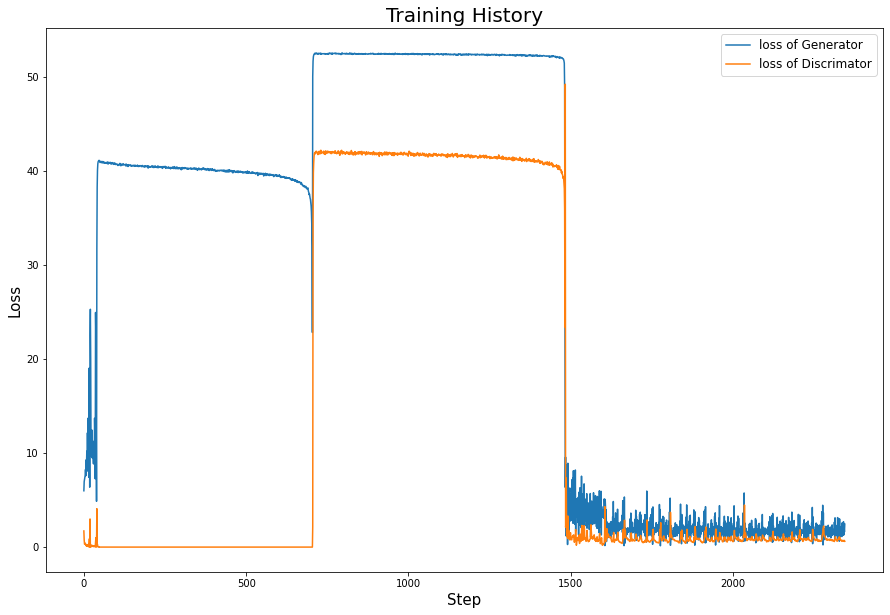

In [ ]:
plt.figure(figsize=(15,10))
plt.title('Training History', fontsize=20)
plt.plot(G_losses, label='loss of Generator')
plt.plot(D_losses, label='loss of Discrimator')
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Step', fontsize=15)
plt.legend(fontsize=12)

음.. 초반에는 Generator 성능이 안 좋은 반면, Discriminator가 가짜와 진짜를 잘 구별하는구나.. 중간에는 Discriminator도 갑자기 정신 못 차리고.. 왜저럴까.. 그래도 말미엔 둘의 사이가 좋아졌구나.. 1500 step 이후 그래프만 보면 어떨까? 진동할까?

- 본인의 해석
1500 step 이후에도 discriminator가 generator보다 내내 낮은 loss를 보인다. 이는 generator가 discriminator가 쉽게 가짜 이미지를 판별할 수 있는 일관된 방식으로 예제를 생성하는 것으로 암시된다.

### 학습 과정에서 생성하는 이미지를 gif로 살펴보자.

In [ ]:
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML

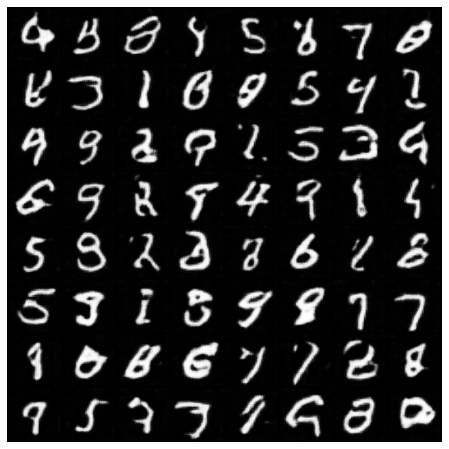

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

학습 데이터 셋 자체가 굉장히 간단하기 때문에 비교적 짧은 시간동안 학습했음에도 불구하고 나름대로 숫자와 비슷한 이미지를 생성했구나.. 학습을 더 오래하면 어떻게 될까? 1epoch 내에서도 모델이 천차만별로 달라질까? 그렇다면, 모델을 더 자주 저장할 필요도 있겠구나..

- 본인의 해석
판별자와 식별자의 성능에 대해 모두 고려해야 하기 때문에 무조건 epochs을 늘린다고 모델이 좋은 이미지를 생성해내는 것은 아니다.